In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gym_trading_env.downloader import download
import pandas_ta as ta

import gymnasium as gym
import gym_trading_env

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from RLTrade.model import DQN, ReplayMemory, Transition

In [2]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
# download(exchange_names = ["binance"],
#     symbols= ["BTC/USDT"],
#     timeframe= "1d",
#     dir = "data",
#     since= datetime.datetime(year= 2019, month= 12, day=31),
#     until= datetime.datetime(year= 2024, month= 1, day=1)
# )
# Import your fresh data
df = pd.read_pickle("./data/binance-BTCUSDT-1d.pkl")

<Axes: xlabel='date_open'>

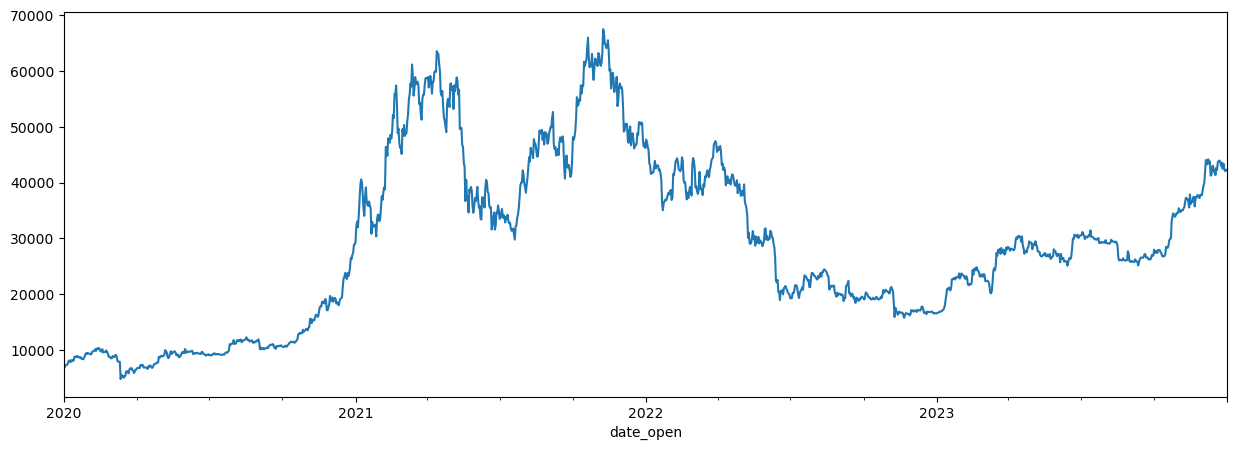

In [3]:
df["close"].plot(figsize=(15, 5))

In [4]:
MyStrategy = ta.Strategy(
    name="OHLC4",
    ta=[
        {"kind": "ohlc4"},
    ]
)

CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)

In [5]:
df.ta.strategy(MyStrategy)
df.dropna(inplace=True)

In [6]:
# length = 500
# random_vales = np.random.randint(0, len(df), length)
# template_df = pd.DataFrame({
#     "open": random_vales, "high": random_vales+1, "low": random_vales-1, "close": random_vales, "volume": random_vales}, 
#     index=[pd.Timestamp("2024-01-01") + pd.Timedelta(hours= i) for i in range(length)]
#     )
# template_df.ta.strategy(MyStrategy)
# features_col = list(template_df.columns)
# features_col

In [7]:
# def build_features(df, features_col):
#     feat = df[features_col].add_prefix("feature_")
#     return pd.concat([df, feat], axis=1)

def build_rolling_features(df, feature_col="OHLC4", window=24):
    window_cols = [f"feature_rolling_{i}" for i in range(window-1)]
    df_copy = df.copy()
    for i in range(len(df)):
        if i < window:
            # pad with first obs
            rolling_window = df_copy.iloc[:i+1][feature_col].values
            pad = window - len(rolling_window)
            rolling_window = np.append(np.zeros(pad) + rolling_window[0], rolling_window)
        else:
            rolling_window = df_copy.iloc[i-window:i][feature_col].values
        rolling_window = np.diff(np.log(rolling_window))
        df_copy.loc[df.index[i], window_cols] = rolling_window
    return df_copy.dropna()

In [13]:
df_train = df.iloc[:int(len(df)*0.8)]
df_test = df.iloc[int(len(df)*0.8):]

df_train = build_rolling_features(df_train, feature_col="OHLC4", window=20)
df_test = build_rolling_features(df_test, feature_col="OHLC4", window=20)

In [14]:
df_train

,open,high,low,close,volume,date_close,OHLC4,feature_rolling_0,feature_rolling_1,feature_rolling_2,...,feature_rolling_9,feature_rolling_10,feature_rolling_11,feature_rolling_12,feature_rolling_13,feature_rolling_14,feature_rolling_15,feature_rolling_16,feature_rolling_17,feature_rolling_18
date_open,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165,2020-01-02,7206.5600,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932,2020-01-03,7075.9300,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018293
2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451,2020-01-04,7146.6225,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018293,0.009941
2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977,2020-01-05,7343.8300,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018293,0.009941,0.027221
2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604,2020-01-06,7381.4850,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018293,0.009941,0.027221,0.005114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,21704.37,21834.99,20042.72,20362.22,443658.285840,2023-03-10,20986.0750,0.021124,-0.002224,-0.002155,...,0.006299,-0.008511,0.005731,0.003165,-0.030432,-0.022154,0.004026,0.000806,-0.006803,-0.014942
2023-03-10,20362.21,20367.78,19549.09,20150.69,618456.467100,2023-03-11,20107.4425,-0.002224,-0.002155,0.006278,...,-0.008511,0.005731,0.003165,-0.030432,-0.022154,0.004026,0.000806,-0.006803,-0.014942,-0.044578
2023-03-11,20150.69,20686.51,19765.03,20455.73,427831.821330,2023-03-12,20264.4900,-0.002155,0.006278,-0.020584,...,0.005731,0.003165,-0.030432,-0.022154,0.004026,0.000806,-0.006803,-0.014942,-0.044578,-0.042769


In [15]:
df_test

,open,high,low,close,volume,date_close,OHLC4,feature_rolling_0,feature_rolling_1,feature_rolling_2,...,feature_rolling_9,feature_rolling_10,feature_rolling_11,feature_rolling_12,feature_rolling_13,feature_rolling_14,feature_rolling_15,feature_rolling_16,feature_rolling_17,feature_rolling_18
date_open,,,,,,,,,,,,,,,,,,,,,
2023-03-14,24112.27,26386.87,23976.42,24670.41,699360.93423,2023-03-15,24786.4925,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-03-15,24670.41,25196.97,23896.95,24285.66,581450.72984,2023-03-16,24512.4975,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011116
2023-03-16,24285.66,25167.40,24123.00,24998.78,439421.32998,2023-03-17,24643.7100,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011116,0.005339
2023-03-17,24998.78,27756.84,24890.00,27395.13,624460.68091,2023-03-18,26260.1875,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011116,0.005339,0.063532
2023-03-18,27395.13,27724.85,26578.00,26907.49,371238.97174,2023-03-19,27151.3675,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.011116,0.005339,0.063532,0.033373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,42508.93,43677.00,42098.69,43428.85,36191.21136,2023-12-28,42928.3675,0.007567,0.003429,-0.004058,...,-0.007259,0.000027,0.017233,0.012794,0.015113,0.003318,-0.003940,-0.010407,-0.000285,-0.010308
2023-12-28,43428.86,43787.57,42241.79,42563.76,35150.52485,2023-12-29,43005.4950,0.003429,-0.004058,-0.035134,...,0.000027,0.017233,0.012794,0.015113,0.003318,-0.003940,-0.010407,-0.000285,-0.010308,0.002321
2023-12-29,42563.76,43111.00,41300.00,42066.95,42597.18912,2023-12-30,42260.4275,-0.004058,-0.035134,-0.021157,...,0.017233,0.012794,0.015113,0.003318,-0.003940,-0.010407,-0.000285,-0.010308,0.002321,0.001795


In [16]:
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(-1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Market Return : 234.87%   |   Portfolio Return : 234.84%   |   Position Changes : 1   |   Episode Length : 1168   |   


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def greedy(state):
    with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)

def epsilon_greedy(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return greedy(state)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
n_actions, n_observations


(3, 21)

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [19]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

history_metrics = []
for i_episode in range(num_episodes):
    # action_stats = {0: 0, 1: 0, 2: 0}
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    episode_reward = 0
    for t in count():
        action = epsilon_greedy(state)
        # action_stats[action.item()] += 1
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_reward += reward.item()
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            metric = env.unwrapped.get_metrics()
            metric["episodic_reward"] = episode_reward
            history_metrics.append(metric)
            break

print('Complete')

Market Return : 234.87%   |   Portfolio Return : -78.54%   |   Position Changes : 680   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 387.22%   |   Position Changes : 762   |   Episode Length : 1168   |   
Market Return : 447.61%   |   Portfolio Return : -109.51%   |   Position Changes : 219   |   Episode Length : 373   |   
Market Return : 234.87%   |   Portfolio Return : 1530.87%   |   Position Changes : 685   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 1082.05%   |   Position Changes : 699   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 1871.26%   |   Position Changes : 732   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 4404.27%   |   Position Changes : 702   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 7294.79%   |   Position Changes : 725   |   Episode Length : 1168   |   
Market Return : 234.87%   |

In [20]:
all_metrics = pd.DataFrame(history_metrics)
all_metrics["Market Return"] = all_metrics["Market Return"].str.rstrip('%').astype('float') / 100.0
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].str.rstrip('%').astype('float') / 100.0

<Axes: >

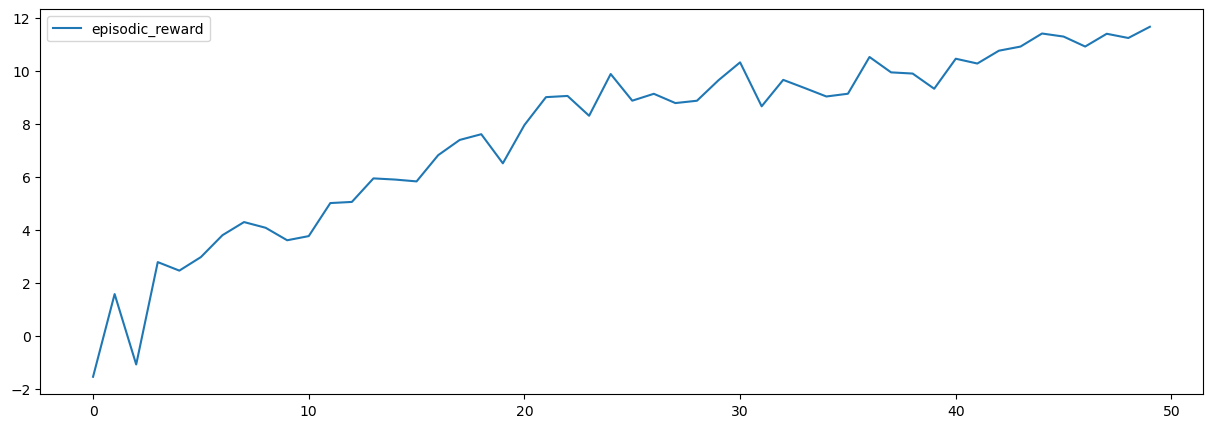

In [21]:
all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))

In [22]:
env_test = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df_test, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )
env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

state, info = env_test.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
done = False
while not done:
    action = greedy(state)
    observation, reward, terminated, truncated, _ = env_test.step(action.item())
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    done = terminated or truncated

Market Return : 71.39%   |   Portfolio Return : -32.87%   |   Position Changes : 164   |   Episode Length : 293   |   


In [23]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

In [24]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()